# Classes and Object Oriented Programming
## Notebook 2

In this notebook you are going to create classes that simulate people. We will be using Pandas to generate the data we will use to create our person objects.

In [1]:
from nose.tools import assert_equal, assert_true, assert_raises, assert_almost_equal

In [102]:
import pandas as pd
import gzip
import pickle
import dateutil
import datetime
from dateutil.relativedelta import *
import numpy.random as ra
import math
import random
import seaborn as sns
import numpy as np
import numbers
import uuid

## Get Surnames

I have downloaded from the [Census Bureau](https://www.census.gov/topics/population/genealogy/data/2000_surnames.html) a csv file with the surnames and their counts in the 2010 census.  

**Problem 1 (5 points)**: Create a Pandas DataFrame named `surnames` from the file `2010_surnames.csv` that has columns `"name"` and `"count"` where count is greater than 10,000.


In [66]:
surnames = pd.read_csv("2010_surnames.csv", 
                       usecols=["name", "count"])
surnames = surnames[surnames["count"]>10000]


## Tests for Problem 1

In [67]:
assert_equal(surnames.shape, (3287,2))

In [68]:
assert_equal(list(surnames.columns), ["name", "count"])

**Problem 2 (10 points):** Create a new column in `surnames` called `"probability"` that is the probability each name occurs in the sample of names (i.e. the count for that name divided by the sum of all the counts). Sort `surnames` so that the rows increase with `"probability"`.

In [69]:
surnames["probability"] = surnames["count"]/surnames["count"].sum()
surnames = surnames.sort_values(by="probability",ascending=True)
surnames.head()


,name,count,probability
3286,KASPER,10005,0.000067
3285,ZELLER,10006,0.000067
3284,SKIPPER,10010,0.000067
3283,CARBONE,10012,0.000067
3282,LAFFERTY,10014,0.000067


## Tests for Problem 2

In [70]:
assert_almost_equal(surnames[surnames["name"] == "YOUNG"]["probability"].values[0], 0.003138555454437736)

In [71]:
assert_almost_equal(surnames[surnames["name"] == "CHAPMAN"]["probability"].values[0], 0.00083938110990776664)

In [72]:
assert_true(surnames["probability"][surnames.index[0]] < surnames["probability"][surnames.index[-1]])

**Problem 3 (xy 5):** Add a column named `"cumulative_probability"` that is for a given name the cumulative sum of all the probabilities for names less common than that name.

The tail of your DataFrame should look like this:

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>name</th>
      <th>count</th>
      <th>probability</th>
      <th>cumulative_probability</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>4</th>
      <td>JONES</td>
      <td>1362755</td>
      <td>0.009179</td>
      <td>0.951855</td>
    </tr>
    <tr>
      <th>3</th>
      <td>BROWN</td>
      <td>1380145</td>
      <td>0.009296</td>
      <td>0.961152</td>
    </tr>
    <tr>
      <th>2</th>
      <td>WILLIAMS</td>
      <td>1534042</td>
      <td>0.010333</td>
      <td>0.971485</td>
    </tr>
    <tr>
      <th>1</th>
      <td>JOHNSON</td>
      <td>1857160</td>
      <td>0.012510</td>
      <td>0.983994</td>
    </tr>
    <tr>
      <th>0</th>
      <td>SMITH</td>
      <td>2376206</td>
      <td>0.016006</td>
      <td>1.000000</td>
    </tr>
  </tbody>
</table>

**Hint:** There is a Pandas DataFrame/Series method for this.

In [73]:
surnames["cumulative_probability"] = surnames["probability"].cumsum()
surnames.tail()

,name,count,probability,cumulative_probability
4,JONES,1362755,0.009179,0.951855
3,BROWN,1380145,0.009296,0.961152
2,WILLIAMS,1534042,0.010333,0.971485
1,JOHNSON,1857160,0.012510,0.983994
0,SMITH,2376206,0.016006,1.000000


## Tests for Problem 3

In [74]:
assert_almost_equal(surnames[surnames["name"] == "WEBBER"]["cumulative_probability"].values[0], 0.21867902035776357)

In [75]:
assert_almost_equal(surnames[surnames["name"] == "JOHNSON"]["cumulative_probability"].values[0], 0.98399423475974246)

**Problem 4 (15):** Write a function `get_lastname` that takes as an argument your modified DataFrame `surnames` and returns a random name based on name frequency. Here is some pseudo-code for the function

function get_lastname  

    Arguments:  
        a positional argument that is a DataFrame with surnames and the cumulative probability for each surname  
        a keyword argument seed with a seed value (default None)   
    Returns: a name   
    
    Set the random number generator seed with seed.   
    Generate a random number (v) between 0 and 1   
    for each row in DataFrame    ask
       is v < row["cumulative_probability"]?    
           if yes then return the name value in this row   
           if no then continue    
           
There is a faster way to achieve this results that uses Pandas selecting with a boolean DataFrame rather than a for loop:

    Arguments:  
        a positional argument that is a DataFrame with surnames and the cumulative probability for each surname  
        a keyword argument seed with a seed value (default None)   
    Returns: a name   
    
    Set the random number generator seed with seed.   
    Generate a random number (v) between 0 and 1   
    
    Select all the rows in the DataFrame where the cumulative probability is greater than v
    Select first row in the resulting DataFrame and return the cumulative probability from that row.


#### We need the seed argument for testing purposes.

In [76]:
import random
def get_lastname(surnames, seed=None):

    random.seed(seed)
    v = random.random()
    for _,row in surnames.iterrows():
        if v < row["cumulative_probability"]:
            return row["name"]

## Tests for Problem 4

In [77]:
assert_equal(get_lastname(surnames, seed=1), 'BATEMAN')

In [78]:
assert_equal(get_lastname(surnames, seed=356789), 'WEBB')

In [79]:
seed = random.randint(0,1000000)
def get_lastname2(surnames, seed=None):
    random.seed(seed)
    v = random.random()
    return surnames[surnames["cumulative_probability"] > v].iloc[0]["name"]
assert_equal(get_lastname(surnames, seed=seed), get_lastname2(surnames, seed=seed))


## Get Mortality Data

We are going to simulate patients living and dying. To do this we need the probability of dying for an individual at a given age. This is available through the [Social Security Administration website](https://www.ssa.gov/oact/STATS/table4c6.html). As we learned in the Pandas module, Pandas can read HTML tables. HTML, however, is notoriously messy and I had to do some hacking to get the data cleaned up to a usable state.


In [80]:
mortality = pd.read_html("https://www.ssa.gov/oact/STATS/table4c6.html", 
                         skiprows=4, 
                         header=None)[0]
mortality = mortality.iloc[0:120,[1,4]]
mortality.rename(columns=dict(zip(mortality.columns, 
                                  ("Male prob. death", 
                                   "Female prob. death"))), 
                 inplace=True)
mortality.head()

,Male prob. death,Female prob. death
0,0.006322,0.005313
1,0.000396,0.000346
2,0.000282,0.000221
3,0.000212,0.000162
4,0.000186,0.000131


## Get USA Municipalities 

Our people need to live somewhere. I've downloaded a csv file with USA municipalities and their populations (`"PEP_2016_PEPANNRES.csv"`).

[Census Website](https://factfinder.census.gov/faces/tableservices/jsf/pages/productview.xhtml?src=bkmk)

**Problem 5 (15 points):** 

1. Use Pandas to read in `PEP_2016_PEPANNRES.csv` into a DataFrame named `municipalities`. The DataFrame should contain the following two columns: "Geography" and "April 1, 2010 - Census". To properly read in the data you will need to use the following keyword argument in `read_csv`:
```Python
encoding="latin1"
```
2. Use the `r2` regular expression object to replace all matches in the DataFrame with an empty string.

3. Similar to what we did with `surnames` create a column `"probabilities"` (using the "April 1, 2010 - Census" column), sort the `municipalities` by `"probabilities"` and create a `"cumulative_probability"` column.

Your resulting DataFrame should look like this:

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>Geography</th>
      <th>April 1, 2010 - Census</th>
      <th>probability</th>
      <th>cumulative_probability</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>9610</th>
      <td>Goss, Missouri</td>
      <td>0.0</td>
      <td>0.000000e+00</td>
      <td>0.000000e+00</td>
    </tr>
    <tr>
      <th>10665</th>
      <td>Monowi, Nebraska</td>
      <td>1.0</td>
      <td>5.203602e-09</td>
      <td>5.203602e-09</td>
    </tr>
    <tr>
      <th>10553</th>
      <td>Gross, Nebraska</td>
      <td>2.0</td>
      <td>1.040720e-08</td>
      <td>1.561081e-08</td>
    </tr>
    <tr>
      <th>14109</th>
      <td>Lotsee, Oklahoma</td>
      <td>2.0</td>
      <td>1.040720e-08</td>
      <td>2.601801e-08</td>
    </tr>
    <tr>
      <th>16043</th>
      <td>Hillsview, South Dakota</td>
      <td>3.0</td>
      <td>1.561081e-08</td>
      <td>4.162882e-08</td>
    </tr>
  </tbody>
</table>

In [81]:
import re
r2 = re.compile(" city| village| town")
municipalities = None

municipalities = pd.read_csv("PEP_2016_PEPANNRES.csv", 
                             usecols=["Geography", "April 1, 2010 - Census"], 
                             skiprows=1, encoding="latin1").replace(r2,"")
municipalities["probability"] = municipalities["April 1, 2010 - Census"]/municipalities["April 1, 2010 - Census"].sum()
municipalities = municipalities.sort_values(by="probability",ascending=True)
municipalities["cumulative_probability"] = municipalities["probability"].cumsum()
municipalities.head()


,Geography,"April 1, 2010 - Census",probability,cumulative_probability
9610,"Goss, Missouri",0.0,0.000000e+00,0.000000e+00
10665,"Monowi, Nebraska",1.0,5.203602e-09,5.203602e-09
10553,"Gross, Nebraska",2.0,1.040720e-08,1.561081e-08
14109,"Lotsee, Oklahoma",2.0,1.040720e-08,2.601801e-08
16043,"Hillsview, South Dakota",3.0,1.561081e-08,4.162882e-08


## Tests for Problem 6

In [82]:
assert_equal(municipalities.columns.tolist(), 
             ['Geography', 
              'April 1, 2010 - Census', 
              'probability',
              'cumulative_probability'])

In [83]:
assert_equal(municipalities.iloc[0]["Geography"], "Goss, Missouri")

In [84]:
assert_equal(municipalities.iloc[3274]["Geography"], "Creston, Washington")

**Problem 6 (5 points):**

Generalize the `get_lastname` function to return the value in an arbitrary column based on an arbitrary test column.

In [85]:
def get_random_attribute(df, return_col, 
                         test_col="cumulative_probability",
                         seed=None):
    random.seed(seed)
    v = random.random()
    return df[df[test_col] > v].iloc[0][return_col]

In [86]:
assert_equal(get_random_attribute(municipalities, 
                                  "Geography",
                                  seed=172),
             'Manassas, Virginia') 

In [87]:
assert_equal(get_random_attribute(surnames, "name",seed=172),"JOHNS")

## Age Distribution
We need distributions for our population ages. Here is information at the [Census Bureau](https://www.census.gov/prod/cen2010/briefs/c2010br-03.pdf). I'm going to just use the geometric distribution in numpy to create a (to me, for this homework) reasonable distribution of ages.


18 99


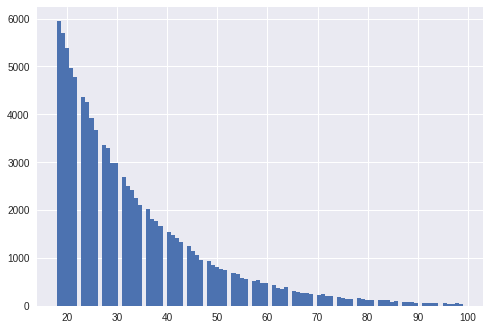

In [88]:

def get_age(minage=17, maxage=100, p=0.06):
    age = minage+ra.geometric(p,1)[0]
    if age < maxage:
        return age
    else:
        return get_age()
ages = pd.Series([get_age() for i in range(100000)])
print(ages.min(), ages.max())
ages.hist(bins=100)

**Problem 7 (5 points):**

Write a function `get_sex` that takes a positional argument the proportion of the population that is female and returns `"F"` or `"M"` based on that proportion. The keyword argument `seed=None` is needed for testing.

```Python
0.52
```

In [89]:
def get_sex(female_proportion, seed=None):
    random.seed(seed)
    if random.random()< female_proportion:
        return "F"
    else:
        return "M"


## Tests for Problem 7

In [90]:
assert_equal(get_sex(0.52, seed=1), "F")

In [91]:
assert_equal(get_sex(0.1, seed=1), "M")

## First Names

**Problem 8 (5 points):** 

The Social Security Administration provides the [names of babies](https://www.ssa.gov/oact/babynames/limits.html) born in the United States between 1880 and 2016. For privacy purposes names occuring fewer than 5 times per year are excluded. A dicctionary containing these name, along with ther probabilities and cumulative probabilites is stored in a compressed pickle file `first_names.pickle.gz`. Use Python to read the dictionary into this notebook.

In [92]:
first_names = None

with gzip.open("first_names.pickle.gz", "rb") as f0:
    first_names = pickle.load(f0)
    

## Tests for Problem 8

In [93]:
assert_equal(list(first_names.keys()), 
                          [1880, 1881, 1882, 1883, 1884, 1885, 
                           1886, 1887, 1888, 1889, 1890, 1891, 
                           1892, 1893, 1894, 1895, 1896, 1897, 
                           1898, 1899, 1900, 1901, 1902, 1903, 
                           1904, 1905, 1906, 1907, 1908, 1909, 
                           1910, 1911, 1912, 1913, 1914, 1915, 
                           1916, 1917, 1918, 1919, 1920, 1921, 
                           1922, 1923, 1924, 1925, 1926, 1927, 
                           1928, 1929, 1930, 1931, 1932, 1933, 
                           1934, 1935, 1936, 1937, 1938, 1939, 
                           1940, 1941, 1942, 1943, 1944, 1945, 
                           1946, 1947, 1948, 1949, 1950, 1951, 
                           1952, 1953, 1954, 1955, 1956, 1957, 
                           1958, 1959, 1960, 1961, 1962, 1963, 
                           1964, 1965, 1966, 1967, 1968, 1969, 
                           1970, 1971, 1972, 1973, 1974, 1975, 
                           1976, 1977, 1978, 1979, 1980, 1981, 
                           1982, 1983, 1984, 1985, 1986, 1987, 
                           1988, 1989, 1990, 1991, 1992, 1993, 
                           1994, 1995, 1996, 1997, 1998, 1999, 
                           2000, 2001, 2002, 2003, 2004, 2005, 
                           2006, 2007, 2008, 2009, 2010, 2011, 
                           2012, 2013, 2014, 2015, 2016])

**Problem 9 (15 points):**

Complete the code for the person class defined below:


```Python
class person(object):
    """
    person class. 
    """
    __sexes = ('M', 'F')
    def __init__(self, name = "John",
                 dob = "",
                 sex = 'F'):
        """Contructor. Names no arguments."""
        self.name = name
        self.dob = dob
        self.sex = sex


    @property
    def name(self):
        ???
    @name.setter
    def name(self,name):
        ???
    @property
    def age(self):
        """
        Returns the person's age in years as an integer.
        
        Age is computed using the different between the 
        date of birth and the current date.
        """
        ???
    @property
    def dob(self):
        return self.__dob
    @dob.setter
    def dob(self, dob):
        self.__dob = dateutil.parser.parse(dob).date()
    @property
    def sex(self):
        ???
    @sex.setter
    def sex(self, value):
        sex = value.upper()[0]
        if sex not in self.__sexes:
            raise ValueError("%s: invalid sex specification"%sex)
        self.__sex = sex

    def __str__(self):
        ???
```

In [94]:
class person(object):
    """
    person class. 
    """
    __sexes = ('M', 'F')
    def __init__(self, name = "John",
                 dob = "",
                 sex = 'F'):
        """Contructor. Names no arguments."""
        self.name = name
        self.dob = dob
        self.sex = sex


    @property
    def name(self):
        return self.__name
    @name.setter
    def name(self,name):
        self.__name = name.strip()
    @property
    def age(self):
        td = datetime.datetime.now().date() - self.__dob
        
        return td.days//365
    @property
    def dob(self):
        return self.__dob
    @dob.setter
    def dob(self, dob):
        self.__dob = dateutil.parser.parse(dob).date()
    @property
    def sex(self):
        return self.__sex
    @sex.setter
    def sex(self, value):
        sex = value.upper()[0]
        if sex not in self.__sexes:
            raise ValueError("%s: invalid sex specification"%sex)
        self.__sex = sex

    def __str__(self):
        return """%s (%s), age %s"""%\
                (self.name, self.sex, self.age)

## Tests for Problem 9

In [95]:
test_person = person(name="Earl", dob="Feb 28, 1929", sex="M")
assert_true("Earl" in test_person.__str__())

In [96]:
test_person = person(name="Earl", dob="Feb 28, 1929", sex="M")
assert_true("88" in test_person.__str__())

In [97]:
test_person = person(name="Donna", dob="March 15, 1947", sex="F")
assert_equal(test_person.age, 70)

In [98]:
assert_raises(ValueError, person, name="Ziggy", 
                                  dob="01/08/1947", 
              sex="Other")


In [99]:
assert_raises(AttributeError, person, name=1947, sex="M", dob="01/08/1947")

**Problem 10 (30 points):**

Define a class `participant` that inherits from `person`. The class adds the following attributes and properties. For properties, store the actual value in a private variable:

* `deceased`: a boolean property set initially to False
    * Define getter/setter properties
* `dod`: a property
    * The actual value is a `datetime.date` object stored as a private attribute 
    * The getter property returns the date in an appropriately formated string
    * The setter property accepts either a string or a datetime.date object
* `residence`: a string property indicating a municipality in the USA.
    * * Define getter/setter properties
* `__study_start`: a datetime.date object initialized to the current date 
    * Initialize in the constructor
    * Define a getter property (def study_start) but not a setter (cannot be modified)
* `__time_in_study`: a `dateutil` `relativedelta` object
    * Define a getter property that returns the number of days in the study as an integer
* `__studyid`: An integer generated with the `uuid` library.
    * Initialize in the constructor
    * Define a getter property but not a setter (cannot be modified)

In addition to the @property and @xyz.setter methods, the class should implement the following methods:

* `increment_study_time`: accepts a `relativedelta` object and increments the `__time_in_study` attribute.
* `dies`: sets `deceased` to `True` and sets `dod` to the study start date plus the time in the study
* `__repr__`
* `__str__`


In [100]:
class participant(person):
    def __init__(self, 
                 residence="", 
                 enrollment_date=None,
                 **kwargs):
        self.residence = residence
        self.deceased = False
        if enrollment_date==None:
            self.__study_start = datetime.datetime.now().date()
        else:
            try:
                self.__study_start = \
                    dateutil.parser.parse(enrollment_date).date()
            except TypeError:
                if isinstance(enrollment_date, datetime.date):
                    self.__study_start = enrollment_date
                else:
                    raise TypeError("invalid date specification")
            
        self.__time_in_study = relativedelta()
        self.__studyid = uuid.uuid1().int
        self.__dod = None
        super(participant, self).__init__(**kwargs)
        
        
    @property
    def enrollment_date(self):
        return self.__study_start.strftime("%B %d, %Y")
    @property
    def days_in_study(self):
        return ((self.__study_start+self.__time_in_study) - \
                 self.__study_start).days
    @property
    def age(self):
        td = self.__study_start+self.__time_in_study - self.dob
        
        return {"years":td.days//365, "months":td.days%365//30}
    
    @property
    def deceased(self):
        return self.__deceased
    @deceased.setter
    def deceased(self, value):
        if not isinstance(value, bool):
            raise TypeError("deceased must be a boolean")
        self.__deceased = value
    @property
    def dod(self):
        try:
            return self.__dod.strftime("%B %d, %Y")
        except:
            return ""
    @dod.setter
    def dod(self, dod):
        try:
            self.__dod = dateutil.parser.parse(dod).date()
        except TypeError:
            if isinstance(dod, datetime.date):
                self.__dod = dod
            else:
                raise TypeError("invalid date specification")
    @property
    def residence(self):
        return self.__residence
    @residence.setter
    def residence(self, value):
        self.__residence = value.strip()
    def dies(self):
        self.deceased = True
        self.dod = self.__study_start+self.__time_in_study
    
    def increment_study_time(self, timedelta):
        if not self.deceased:
            self.__time_in_study += timedelta
    def __str__(self):
        return """%s (%s), age %s years and %s months, of %s%s"""%\
                (self.name, 
                 self.sex, 
                 self.age["years"],
                 self.age["months"],
                 self.residence, 
                 " (deceased)" if self.deceased else "")
    def __repr__(self):
        return """instance of participant\nName:%s\nID:%s\nEnrollment Date:%s\nStudy Days:%s\nDOB:%s\nDeceased:%s\nDOD:%s\nResidence:%s"""%\
                   (self.name, 
                    self.__studyid,
                    self.enrollment_date,
                    self.days_in_study,
                    self.dob.strftime("%B %d, %Y"),
                    self.__deceased,
                    self.dod,
                    self.residence)
    def __lt__(self,p):
        return self.__dod < p.__dod
    def __le__(self,p):
        return self.__dod <= p.__dod
    def __eq__(self,p):
        return self.__dod == p.__dod
    def __gt__(self,p):
        return self.__dod > p.__dod
    def __ge__(self,p):
        return self.__dod >= p.__dod
    def __ne__(self,p):
        return self.__dod != p.__dod    

## Tests for Problem 10

In [103]:
p1= participant(residence="Salt Lake City", 
                name="Brian", 
                dob="5/24/1968",
                enrollment_date = "October 28, 2017",
                sex='male')
assert_true(isinstance(p1,person))

In [104]:
p1= participant(residence="Salt Lake City", 
                name="Brian", 
                dob="5/24/1968",
                enrollment_date = "October 28, 2017",
                sex='male')
p1.increment_study_time(relativedelta(months=+24))
assert_true(p1.days_in_study, 730)

In [105]:
p1= participant(residence="Salt Lake City", 
                name="Brian", 
                dob="5/24/1968",
                enrollment_date = "October 28, 2017",
                sex='male')
p1.increment_study_time(relativedelta(months=+36))
p1.dies()
assert_equal(p1.age, {'months': 5, 'years': 52})

In [106]:
p1= participant(residence="Salt Lake City", 
                name="Brian", 
                dob="5/24/1968",
                enrollment_date = "October 28, 2017",
                sex='male')
p1.increment_study_time(relativedelta(months=+36))
p1.dies()
assert_equal(p1.deceased, True)

In [107]:
p1= participant(residence="Salt Lake City", 
                name="Brian Chapman", 
                dob="5/24/1968",
                enrollment_date = "October 28, 2017",
                sex='male')
p1.increment_study_time(relativedelta(months=+12))
assert_equal(p1.deceased, False)

In [108]:
p1= participant(residence="Salt Lake City", 
                name="Brian Chapman", 
                dob="5/24/1968",
                enrollment_date = "October 28, 2017",
                sex='male')
assert_true("Chapman" in p1.__str__())
#assert_equal(p1.deceased, False)

In [109]:
p1= participant(residence="Salt Lake City", 
                name="Brian Chapman", 
                dob="5/24/1968",
                enrollment_date = "October 28, 2017",
                sex='male')
p1.increment_study_time(relativedelta(months=+6))
assert_true("182" in p1.__repr__())

**Problem 11 (25 points):**

Complete and correct the function `generateRandomPersonAttributes` so that it properly returns a `participant` object with randomly determined attributes
```Python
def generateRandomPersonAttributes(surnames, first_names, 
                                   municipalities,
                                   proportion_female=0.52):
    sex = get_sex
    age = get_age
    year = datetime.datetime.now().year-???
    dob = (datetime.date(datetime.datetime.now.year-age, 1,1)+\
        relativedelta(days=+random.randint(0,???))).strftime("%B %d, %Y")
    f_name = get_random_attribute(first_names???, ???)
    l_name = get_random_attribute(surnames, ???).capitalize
    residence = get_random_attribute(municipalities, ???)
    return participant(residence=residence, 
                name="??? ???"%(f_name, l_name), 
                dob=???,
                sex=sex)
```

In [110]:
def generateRandomPersonAttributes(surnames, first_names, 
                                   municipalities,
                                   proportion_female=0.52):
    sex = get_sex(proportion_female)
    age = get_age()
    year = datetime.datetime.now().year-age
    dob = (datetime.date(datetime.datetime.now().year-age, 1,1)+\
        relativedelta(days=+random.randint(0,364))).strftime("%B %d, %Y")
    f_name = get_random_attribute(first_names[year][sex], "name")
    l_name = get_random_attribute(surnames, "name").capitalize()
    residence = get_random_attribute(municipalities, "Geography")
    return participant(residence=residence, 
                name="%s %s"%(f_name, l_name), 
                dob=dob,
                sex=sex)

## Tests for Problem 11

In [111]:
participants = \
[generateRandomPersonAttributes(surnames, 
                                first_names, 
                                municipalities) for i in range(5)]
assert_equal(len(participants),5)

In [112]:
participants = \
[generateRandomPersonAttributes(surnames, 
                                first_names, 
                                municipalities) for i in range(5)]
for p in participants:
    assert_true(isinstance(p,participant))

In [113]:
participants = \
[generateRandomPersonAttributes(surnames, 
                                first_names, 
                                municipalities) for i in range(1000)]

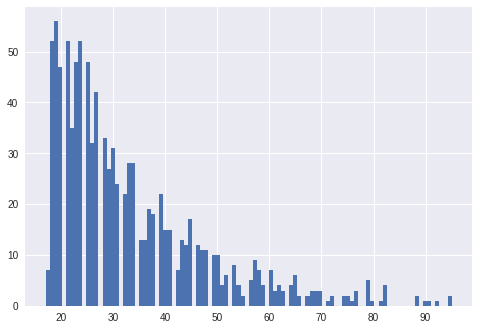

In [114]:
pd.Series([p.age["years"] for p in participants]).hist(bins=100)

## A Function to Run the "Study"

In [115]:
def increment_study(participants, mortality, unit=10):
    delta = 365/unit
    mkeys = {"M":"Male prob. death", "F":"Female prob. death"}
    for p in participants:
        p.increment_study_time(relativedelta(days=+unit))
        if random.random()< mortality.iloc[p.age["years"]][mkeys[p.sex]]/delta:
            p.dies()
    return None
    

In [116]:

while True:
    living = [p for p in participants if not p.deceased]
    if len(living)%200 == 0:
        print(len(living))
    if not living:
        break
    increment_study(living, mortality)
    

1000
800
800
800
600
600
600
600
400
200
200
200
200
0


In [ ]:
sns.distplot([p.age["years"] for p in participants])

In [ ]:
pd.Series([p.age["years"] for p in participants]).hist(bins=100)

In [ ]:
np.mean([p.age["years"] for p in participants if p.sex == "M"])
np.mean([p.age["years"] for p in participants if p.sex == "F"])

**Problem 12 (15 points):** Write a function `get_participant_df` that takes a list of participant objects and returns a Pandas DataFrame witht he following columns:
['Age', 'Days in Study', 'First Name', 'Last Name', 'Sex', 'State'].

Each row in the DataFrame corresponds to a particular participant with the column values the appropriate values from a participant object.

In [ ]:
def get_participant_df(participants):
    plist = []
    for p in participants:
        plist.append(
            {"First Name":p.name.split()[0],
             "Last Name":p.name.split()[1],
             "Sex":p.sex,
             "Age":p.age["years"]+p.age["months"]/12,
             "Days in Study":p.days_in_study,
             "State":p.residence.split(",")[1].strip()})
    pdf = pd.DataFrame(plist)
    return pdf

## Tests for Problem 12

In [ ]:
pdf = get_participant_df(participants)

In [ ]:
assert_equal(set(pdf.columns),
             set(['Age', 'First Name', 'Days in Study',
                  'Last Name', 'Sex', 'State']))

In [ ]:
isinstance(pdf[pdf["Sex"]=="M"]["Age"].mean(), numbers.Real)

In [ ]:
assert_true(isinstance(pdf.iloc[0]["Days in Study"], numbers.Integral))

In [ ]:
sns.kdeplot(data=pdf[pdf["Sex"]=="M"]["Age"], 
            label="Male", color="Blue")
sns.kdeplot(data=pdf[pdf["Sex"]=="F"]["Age"],
            label="Female", color="pink")


In [ ]:
sns.boxplot(x="Sex", y="Age", data=pdf);

In [ ]:
sns.countplot(x="Sex", data=pdf);

In [ ]:
sns.countplot(x="Sex", data=pdf[pdf["Age"]>90]);

**Problem 13 (10 points):** Write a function `create_obituaries` that takes a list of participant objects, a filename, writes out obituaries for each participant in ascending order by date of death. Your file should look something like this:

Jerry Peck, age 82, of Detroit Lakes, Minnesota, died April 06, 2018   
John Conley, age 96, of Kokomo, Indiana, died May 16, 2018   
Jeffery Meyer, age 32, of Wilson's Mills, North Carolina, died May 26, 2018   
Kenneth Jackson, age 54, of Portland, Oregon, died August 04, 2018   
Heather Johnson, age 46, of Sunrise, Florida, died August 24, 2018   
Kristen Holland, age 31, of Town and Country, Missouri, died September 13, 2018   

In [120]:

def create_obituaries(participants, fname):
    with open(fname, "w") as f0:
        participants.sort()
        for p in participants:
            f0.write("%s, age %s, of %s, died %s\n"%(p.name, 
                                                     p.age["years"], 
                                                     p.residence, 
                                                     p.dod))

## Tests for Problem 13

In [125]:
rdate = re.compile(r"""(?P<month>[A-Z][a-z]+) (?P<day>\d{2,2}), (?P<year>\d{4,4})""")
fname = "test_obits.txt"
create_obituaries(participants, fname)
with open(fname) as f0:
    data = f0.readlines()
os.remove(fname)
m0 = rdate.search(data[0])
ml = rdate.search(data[-1])
assert_true(int(m0.group("year")) < int(ml.group("year")))

In [126]:
import os
fname = "test_obits.txt"
create_obituaries(participants, fname)

with open(fname) as f0:
    data = f0.readlines()
os.remove(fname)
m0 = rdate.search(data[0])
ml = rdate.search(data[-1])
assert_equal(len(data), len(participants))
